# Paper Mehrklassenklassifikation mit Neuronalen Netzen


## Imports

In [1]:
import os
import csv
import cv2
import numpy as np
import pandas as pd
import json 

# Plotting
import matplotlib.pyplot as plt
import seaborn as sn

# Tensorflow
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import load_model

# Tensorflow imports for ResNet structure
from tensorflow import Tensor
from tensorflow.keras.layers import Input, Conv2D, ReLU, BatchNormalization, Add, AveragePooling2D, Flatten, Dense, MaxPooling2D
from tensorflow.keras.models import Model

# Sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

## Globale Variablen
Definiere an dieser Stelle alle Variablen, die global verwendet werden, z.B.: Pfadnamen

In [2]:
# Define path to data
DATA_PATH = "../data/GTSRB/Final_Training/Images"
DATA_PATH_HOG = "../data/GTSRB/Final_Training_HOG/HOG/HOG_01"

HOLDOUT_DATA_PATH = "../data/GTSRB/Final_Test/Images"
HOLDOUT_DATA_PATH_HOG = "../data/GTSRB/Final_Test_HOG/HOG/HOG_01"

CLASS_ID_SIGN_MAP = "../data/GTSRB/Final_Training/tf_signs_mapping.csv"
N_CLASSES = 43

## 1. Datenaufbereitung
Hinweise findest du hier: https://keras.io/getting_started/intro_to_keras_for_engineers/#data-loading-amp-preprocessing

In [3]:
def readHOGFeatures(rootpath):
    """
    Reads traffic sign HOG data for German Traffic Sign Recognition Benchmark.

    Arguments: path to the traffic sign data, for example './GTSRB/Final_Training_HOG/HOG/HOG_01'
    Returns:   list of hog_features_vector, list of corresponding labels
    
    """
    
    hog_features_vector = []
    labels = []
    
    # loop over all 42 classes
    for c in range(0,N_CLASSES):
        # subdirectory for class
        prefix = rootpath + '/' + format(c, '05d') + '/'
        
        # read hog features file
        for txtfile in os.listdir(prefix):
            with open(os.path.join(prefix,txtfile)) as fp:
                # loop over lines to read HOG-Vector
                tmp = [float(line) for line in fp]
            
            # add hog feature vector
            hog_features_vector.append(tmp)
            
            # the class column is the label
            labels.append(c)

    return hog_features_vector, labels


def readTrafficSigns(rootpath):
    """
    Reads traffic sign data for German Traffic Sign Recognition Benchmark.

    Arguments: path to the traffic sign data, for example './GTSRB/Training'
    Returns:   list of images, list of corresponding labels
    
    """
    
    images = []
    labels = []
    
    # loop over all 42 classes
    for c in range(0,N_CLASSES):
        # subdirectory for class
        prefix = rootpath + '/' + format(c, '05d') + '/'
        
        # annotations file
        gtFile = open(prefix + 'GT-'+ format(c, '05d') + '.csv')
        
        # csv parser for annotations file
        gtReader = csv.reader(gtFile, delimiter=';')
        
        # Skip header
        next(gtReader)
        
        # loop over all images in current annotations file
        for row in gtReader:
            # the 1th column is the filename
            images.append(plt.imread(prefix + row[0]))
            
            # the 8th column is the label
            labels.append(int(row[7]))
            
        gtFile.close()
    
    return images, labels

def resizeImages(images, width=32, height=32):
    """
    Resize image to unify dimensions of the images
    
    """
    # Initialization
    unified_img = []
    normalized_img = []
    
    # Resize images
    for img in images:
        img = img.copy()
        unified_img.append(cv2.resize(img, (width, height)))

    # Normalize 
    for img in unified_img:
        R, G, B = cv2.split(img)
        img_r = cv2.equalizeHist(R)
        img_g = cv2.equalizeHist(G)
        img_b = cv2.equalizeHist(B)
        normalized_img.append(cv2.merge((img_r, img_g, img_b)))
        
    print("Image Size: {} x {}".format(width, height))
        
    return normalized_img, width, height

def plotImages(X, labels, title, width=32, height=32):
    
    fig, axes = plt.subplots(
        3,15,
        figsize=(15,3),
        subplot_kw={'xticks':[], 'yticks':[]},
        gridspec_kw=dict(hspace=0.01, wspace=0.01)
    )

    for i, ax in enumerate(axes.flat):
        ax.imshow(X[i], cmap="gray")
        ax.text(2, 30, str(labels[i]), fontsize=15, c="white")
        
    fig.suptitle(title, fontsize=10)
    
def one_hot_encode(y):
    """
    Converts featuers from List of strings to one hot encoded labels
    """
    
    class_ids = y.astype(np.int)
    encoded = pd.get_dummies(class_ids).to_numpy()
    
    return encoded

def one_hot_decode(y, y_encoded):
    """
    Decodes one hot encoded data
    """
    
    class_ids = y.astype(np.int)
    decoded = pd.DataFrame(y_encoded).idxmax(1).astype(str).to_numpy()
    
    return decoded
        
def preprocessHOGData(rootpath):
    """
    Loads the data and performs necessary preprocessing steps
    
    Parameters
    ----------
    path to the traffic sign data, for example './GTSRB/Training'
    
    Returns
    -------
    X_train : numpy.Array
    X_test  : numpy.Array
    y_tain  : numpy.Array
    y_test  : numpy.Array
    
    """
    
    # Load Data
    hog_features, labels = readHOGFeatures(rootpath)
    
    # Convert list of labels to array of labels
    unified_img = np.array(hog_features)
    labels = np.array(labels)
    
    # 
    shuffle_indexes = np.arange(unified_img.shape[0])
    np.random.shuffle(shuffle_indexes)
    hog_shuffled = unified_img[shuffle_indexes]
    labels_shuffled = labels[shuffle_indexes]
    
    # Perform train test split
    X_train, X_rest, y_train, y_rest = train_test_split(hog_shuffled, labels_shuffled, test_size=0.3, random_state=42)
    X_val, X_test, y_val, y_test = train_test_split(X_rest, y_rest, test_size=0.5, random_state=42)


    # Save unformatted labels
    labels_train = y_train
    labels_val = y_val
    labels_test = y_test
    
    
    # One hot encode labels
    y_train = one_hot_encode(y_train)
    y_val = one_hot_encode(y_val)
    y_test = one_hot_encode(y_test)
    
    return X_train, X_val, X_test, y_train, y_val, y_test, labels_train, labels_val, labels_test
        

def preprocessData(rootpath):
    """
    Loads the data and performs necessary preprocessing steps
    
    Parameters
    ----------
    path to the traffic sign data, for example './GTSRB/Training'
    
    Returns
    -------
    X_train : numpy.Array
    X_test  : numpy.Array
    y_tain  : numpy.Array
    y_test  : numpy.Array
    
    """
    
    # Load Data
    images, labels = readTrafficSigns(rootpath)
    
    # Unify image dimensions
    unified_img, max_width, max_height = resizeImages(images, width=32, height=32)
    
    # Convert list of labels to array of labels
    unified_img = np.array(unified_img)
    labels = np.array(labels)
    
    # Shuffle arrays
    shuffle_indexes = np.arange(unified_img.shape[0])
    np.random.shuffle(shuffle_indexes)
    images_shuffled = unified_img[shuffle_indexes]
    labels_shuffled = labels[shuffle_indexes]
    
    # Perform train test split
    X_train, X_rest, y_train, y_rest = train_test_split(images_shuffled, labels_shuffled, test_size=0.3, random_state=42)
    X_val, X_test, y_val, y_test = train_test_split(X_rest, y_rest, test_size=0.5, random_state=42)

    # Save unformatted labels
    labels_train = y_train
    labels_val = y_val
    labels_test = y_test
    
    # One hot encode labels
    y_train = one_hot_encode(y_train)
    y_val = one_hot_encode(y_val)
    y_test = one_hot_encode(y_test)
    
    return X_train, X_val, X_test, y_train, y_val, y_test, labels_train, labels_val, labels_test
        

def preprocessIMGandHOG(img_rootpath, hog_rootpath):
    """
    Loads the data and performs necessary preprocessing steps
    
    Parameters
    ----------
    path to the traffic sign data, for example './GTSRB/Training'
    
    Returns
    -------
    X_train : numpy.Array
    X_test  : numpy.Array
    y_tain  : numpy.Array
    y_test  : numpy.Array
    """
    

    # Load HOG Data
    hog_features, labels_hog = readHOGFeatures(hog_rootpath)
    # Convert list of labels to array of labels
    hog_features = np.array(hog_features)
    labels_hog = np.array(labels_hog)
    # # Shuffle Sequence 
    # shuffle_indexes = np.arange(hog_features.shape[0])
    # np.random.shuffle(shuffle_indexes)
    
    # Load IMG Data
    images, labels = readTrafficSigns(img_rootpath)
    # Unify image dimensions
    unified_img, max_width, max_height = resizeImages(images, width=32, height=32)
    
    # Convert list of labels to array of labels
    unified_img = np.array(unified_img)
    labels = np.array(labels)

    # ASSERT LABELS AND SHAPES ARE THE SAME
    np.testing.assert_array_equal(labels, labels_hog)
    assert hog_features.shape[0] == unified_img.shape[0]
    
    # Shuffle arrays
    shuffle_indexes = np.arange(unified_img.shape[0])
    np.random.shuffle(shuffle_indexes)
    
    # Perform train test split
    index_train, index_rest = train_test_split(shuffle_indexes, test_size=0.3, random_state=42)
    index_test, index_val = train_test_split(index_rest, test_size=0.5, random_state=42)

    X_hog_train = hog_features[index_train]
    X_hog_val = hog_features[index_val]
    X_hog_test = hog_features [index_test]
    X_img_train = unified_img[index_train]
    X_img_val = unified_img[index_val]
    X_img_test =  unified_img[index_test]
    y_train = labels[index_train]
    y_val = labels[index_val]
    y_test = labels[index_test] 
    
    # Save unformatted labels
    labels_train = y_train
    labels_val = y_val
    labels_test = y_test
    
    # One hot encode labels
    y_train = one_hot_encode(y_train)
    y_val = one_hot_encode(y_val)
    y_test = one_hot_encode(y_test)
    
    return X_hog_train, X_hog_val, X_hog_test, X_img_train, X_img_val, X_img_test, y_train, y_val, y_test, labels_train, labels_val, labels_test

def plotAugmentationExample(image, width=32, height=32):
    """
    Plots 8 augmented samples of an image
    
    Parameters
    ----------
    image : numpy.Array
        Examplary image
    width : Integer
        width of the image
    height : Integer
        heigth of the image
    
    """
    
    # Extract one example image
    image = image.copy()
    image = image.reshape(1, width, height, 3)

    # create image data augmentation generator
    datagen = tf.keras.preprocessing.image.ImageDataGenerator(
        rotation_range=15,
        zoom_range=0.15,
        width_shift_range=0.15,
        height_shift_range=0.15,
        shear_range=0.3
    )

    # prepare iterator
    it = datagen.flow(image, batch_size=1)

    # Create figure
    fig, axes = plt.subplots(
        2,4,
        figsize=(8,4),
        subplot_kw={'xticks':[], 'yticks':[]},
        gridspec_kw=dict(hspace=0.01, wspace=0.01)
    )

    for i, ax in enumerate(axes.flat):
        # generate batch of images
        batch = it.next()

        # convert to unsigned integers for viewing
        augmented_image = batch[0].astype('uint8')

        # Plot augmented image
        ax.imshow(augmented_image, cmap="gray")
        ax.text(2, 30, "sample_id = " + str(i), fontsize=12, c="white")

    title = "Image augmentation example"
    fig.suptitle(title, fontsize=20)

In [ ]:
X_hog_train, X_hog_val, X_hog_test, X_img_train, X_img_val, X_img_test, y_train, y_val, y_test, labels_train, labels_val, labels_test = preprocessIMGandHOG(DATA_PATH, DATA_PATH_HOG)


print("X_hog_train.shape = {}".format(X_hog_train.shape))
print("X_img_train.shape = {}".format(X_img_train.shape))
print("y_tain.shape = {}".format(y_train.shape))
print("X_hog_val.shape = {}".format(X_hog_val.shape))
print("X_img_val.shape = {}".format(X_img_val.shape))
print("y_val.shape = {}".format(y_val.shape))
print("X_hog_test.shape = {}".format(X_hog_test.shape))
print("X_img_test.shape = {}".format(X_img_test.shape))
print("y_test.shape = {}".format(y_test.shape))

In [4]:
# Read all the Traffic Sign data
X_hog_train, X_hog_val, X_hog_test, y_train, y_val, y_test, labels_train, labels_val, labels_test = preprocessHOGData(DATA_PATH_HOG)

print("X_train.shape = {}".format(X_hog_train.shape))
print("y_tain.shape = {}".format(y_train.shape))
print("X_val.shape = {}".format(X_hog_val.shape))
print("y_val.shape = {}".format(y_val.shape))
print("X_test.shape = {}".format(X_hog_test.shape))
print("y_test.shape = {}".format(y_test.shape))

/tmp/ipykernel_18580/2410148466.py:117: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  class_ids = y.astype(np.int)


X_train.shape = (27446, 1568)
y_tain.shape = (27446, 43)
X_val.shape = (5881, 1568)
y_val.shape = (5881, 43)
X_test.shape = (5882, 1568)
y_test.shape = (5882, 43)


In [ ]:
# Read all the Traffic Sign data
X_train, X_val, X_test, y_train, y_val, y_test, labels_train, labels_val, labels_test = preprocessData(DATA_PATH)

print("X_train.shape = {}".format(X_train.shape))
print("y_tain.shape = {}".format(y_train.shape))
print("X_val.shape = {}".format(X_val.shape))
print("y_val.shape = {}".format(y_val.shape))
print("X_test.shape = {}".format(X_test.shape))
print("y_test.shape = {}".format(y_test.shape))

# Plot first 44 examples of X_train and X_test
# plotImages(X_train, labels_train, title="Traing data")
# plotImages(X_val, labels_val, title="Validation data")
# plotImages(X_test, labels_test, title="Test data")

# Plot Augmentation Example
# plotAugmentationExample(image=X_train[125])

In [ ]:
fig, axes = plt.subplots(
        1,1,
        figsize=(8,8),
        subplot_kw={'xticks':[], 'yticks':[]},
        gridspec_kw=dict(hspace=0.01, wspace=0.01)
    )

axes.imshow(X_val[8])

In [ ]:
# Plot Augmentation Example
plotAugmentationExample(image=X_val[8])

## 2.  Aufbau des Modells
Zum Aufbau deines Modells kannst du dich an die gezeigten Beispiele richten. Implementiere zuerst ein einfaches Modell, welches du je nach Performance erweitern kannst. 

Unten findest du die Auflistung der Schichten (Layers), die du für dein Modell miteinander kombinieren kannst. 


class RoadSignClassifier:Überlege dir, welche Layers für die Klassifikationsaufgabe mit HOG-Features gut sind und welche Layer sich für die Klassifikationsaufgabe mit ppm-Dateien eignen.

In [ ]:
class RoadSignClassifier:
    """
    Classifier for 
    
    Attributes
    ----------
    self.name : String
        name of model
    width : Integer
        width of input images
    height : Integer
        heigth of input images
    depth : Integer
        
    """
    def __init__(self, X_train, X_val, X_test, y_train, y_val, y_test, N_classes, name):
        """
        Initialization of RoadSignClassifier instance
        
        """
        
        # Model name
        self.name = name
        
        # Dimensions of the data set
        self.width = X_train.shape[1]
        self.height = X_train.shape[2]
        self.depth = X_train.shape[3]
        
        # Data
        self.X_train = X_train
        self.X_val = X_val
        self.X_test = X_test
        
        # Labels
        self.y_train = y_train
        self.y_val = y_val
        self.y_test = y_test
        self.labels_train = None
        self.labels_test = None
        self.labels_val = None
        
        # Predicted Data
        self.y_test_pred = None
        self.labels_test_pred = None
        
        # Number of classes
        self.N_classes = N_classes
        
        # Instance of keras model
        self.model = None
        
        # Hyperparameters of model
        self.learning_rate = 0.001
        self.epochs = 20
        self.batch_size = 64
        self.patience = None
        
        # Augmentation Parameters
        self.rotation_range = 10
        self.zoom_range = 0.15
        self.width_shift_range = 0.1
        self.height_shift_range = 0.1
        self.shear_range = 0.15
        self.horizontal_flip = False
        self.vertical_flip = False
        
        # Training history
        self.training_hist = None
        
        # Evaluation
        self.classification_report = None
        self.test_accuracy = None
        self.confusion_matrix = None
        self.unique_labels = None


    def createModel(self):
        """
        Creates Sequential model using tensorflow keras
        """
        
        # Define input shape
        inputShape = (self.height, self.width, self.depth)
        
        # Initialize model
        model = tf.keras.Sequential()
        model.add(tf.keras.layers.Conv2D(16, (3, 3), input_shape=inputShape, activation="relu"))
        
        model.add(keras.layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu'))
        model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
        model.add(tf.keras.layers.BatchNormalization(axis=-1))
        
        model.add(tf.keras.layers.Conv2D(64, (3, 3), activation="relu"))
        model.add(tf.keras.layers.Conv2D(128, (3, 3), activation="relu"))
        model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
        model.add(tf.keras.layers.BatchNormalization(axis=-1))
        
        model.add(tf.keras.layers.Flatten())
        model.add(tf.keras.layers.Dense(512, activation="relu"))
        model.add(tf.keras.layers.BatchNormalization())
        model.add(tf.keras.layers.Dropout(rate=0.5))
        
        model.add(tf.keras.layers.Dense(self.N_classes, activation="softmax"))
        
        # Define optimizer
        optimizer = tf.keras.optimizers.Adam(
            learning_rate=self.learning_rate, 
            decay=self.learning_rate / (self.epochs)
        )

        # Compile model
        model.compile(
            optimizer=optimizer, 
            loss="categorical_crossentropy", 
            metrics=["accuracy"]
        )
        
        self.model = model
    
    def fit(self):
        """
        Definition of callbacks, specificaiton of data augmentation & fit of the model
        
        """
        
        # Specify early stopping criterion
        callback = tf.keras.callbacks.EarlyStopping(
            monitor='val_loss', 
            patience=10,
            restore_best_weights=True
        )

        # Perform data augmentation on the data, to increase the diversity of your training 
        # set by applying random (but realistic) transformations, such as image rotation.
        data_augmentation = tf.keras.preprocessing.image.ImageDataGenerator(
            rotation_range=self.rotation_range,
            zoom_range=self.zoom_range,
            width_shift_range=self.width_shift_range,
            height_shift_range=self.height_shift_range,
            shear_range=self.shear_range,
            horizontal_flip=self.horizontal_flip,
            vertical_flip=self.vertical_flip
        )

        # Fit model
        # TODO: Why is data_augmentation commented out?
        self.training_hist = self.model.fit(
            #data_augmentation.flow(self.X_train, self.y_train, batch_size=self.batch_size),
            self.X_train, 
            self.y_train, 
            batch_size=self.batch_size,
            epochs=self.epochs,
            validation_data=(self.X_val, self.y_val),
            callbacks=callback,
            verbose=1
        )
        
        # Save model
        self.model.save('models/' + self.name)
        
    def evaluate(self):
        """
        Performs evaluation of the model based on test accuracy and confusion matrix
        
        """
        
        # Predict Test data
        self.y_test_pred = self.model.predict(self.X_test)
        
        # Decode predicted one-hot-encoded labels
        self.labels_test_pred = one_hot_decode(self.labels_test, self.y_test_pred)
        
        # Compute classification report
        self.classification_report = classification_report(
            self.labels_test.astype(int), 
            self.labels_test_pred.astype(int)
        )
        print(self.classification_report)
                                           
        # Evalueate trained model with test data
        loss, self.test_accuracy = self.model.evaluate(
            self.X_test,
            self.y_test,
            verbose=0
        )
        
        # Compute Confusion Matrix
        y_true = self.labels_test
        y_pred = self.labels_test_pred
        self.unique_labels = np.unique(self.labels_test.astype(int)).astype(str)
        self.confusion_matrix = confusion_matrix(y_true, y_pred, labels=self.unique_labels)
        
        # Save classification report as .txt file
        filename = "models/" + "report_" + self.name
        
        # Delete old model report from file
        open(filename, "w").close()
        
        # Write new model report to file
        with open(filename, "a") as f:
            print(self.classification_report, file=f)
            print("Test loss = {}".format(loss), file=f)
            print("Test accuracy = {}".format(self.test_accuracy), file=f)
    
    def plotLossHistory(self):
        """
        Plots training history
        
        """
        loss_history = self.training_hist.history['loss']
        validation_loss = self.training_hist.history['val_loss']
        
        fontsize = 12

        %matplotlib inline
        plt.figure(dpi=90)
        plt.semilogy(loss_history)
        plt.semilogy(validation_loss)
        plt.title("Training history of {}".format(self.name), fontsize=fontsize)
        plt.xlabel("Epoch", fontsize=fontsize)
        plt.ylabel("Loss", fontsize=fontsize)
        plt.legend(['loss', 'validation_loss'], fontsize=fontsize)
        
        # Save figure
        filename = "figures/traning_hist_" + self.name
        plt.savefig(filename)
        plt.show()
        
        

In [5]:
class MLPHOGClassifier:
    """
    Classifier for 
    
    Attributes
    ----------
    self.name : String
        name of model
    hog_vector_length : Integer
        length of input hog vector
        
    """
    
    def __init__(self, X_train, X_val, X_test, y_train, y_val, y_test, N_classes, name):
        """
        Initialization of RoadSignClassifier instance
        
        """
        
        # Model name
        self.name = name
        
        # Dimensions of the data set
        self.hog_vector_length = X_train.shape[1]
        
        # Data
        self.X_train = X_train
        self.X_val = X_val
        self.X_test = X_test
        
        # Labels
        self.y_train = y_train
        self.y_val = y_val
        self.y_test = y_test
        self.labels_train = None
        self.labels_test = None
        self.labels_val = None
        
        # Predicted Data
        self.y_test_pred = None
        self.labels_test_pred = None
        
        # Number of classes
        self.N_classes = N_classes
        
        # Instance of keras model
        self.model = None
        self.patience = None
        self.learning_rate = 0.01
        self.epochs = 20
        self.batch_size = 64
        self.dropout = 0.1
        
        
        # Training history
        self.training_hist = None
        
        # Evaluation
        self.classification_report = None
        self.test_accuracy = None
        self.confusion_matrix = None
        self.unique_labels = None
        
    
    def createModel(self):
        # Define input shape
        inputShape = (self.hog_vector_length)
        # Initialize model
        model = tf.keras.Sequential()
        model.add(keras.Input(shape=inputShape))
         
        # Add Layers
        model.add(keras.layers.Dense(500, activation="relu"))
        model.add(keras.layers.Dense(500, activation="relu"))
        model.add(tf.keras.layers.Dropout(rate=self.dropout))
        model.add(keras.layers.Dense(400, activation="relu"))
        model.add(keras.layers.Dense(250, activation="relu"))
        model.add(tf.keras.layers.Dropout(rate=self.dropout))
        model.add(keras.layers.Dense(250, activation="relu"))
        model.add(keras.layers.Dense(100, activation="relu"))
        
        # Add Final Layer
        model.add(tf.keras.layers.Dense(self.N_classes, activation="softmax"))

        # Define optimizer
        optimizer = tf.keras.optimizers.Adam(
            learning_rate=self.learning_rate, 
            decay=self.learning_rate / (self.epochs)
        )

        # Compile model
        model.compile(
            optimizer=optimizer, 
            loss="categorical_crossentropy", 
            metrics=["accuracy"]
        )
        
        self.model = model
    
    def fit(self):
        """
        Definition of callbacks, specificaiton of data augmentation & fit of the model
        
        """
        
        # Specify early stopping criterion
        callback = tf.keras.callbacks.EarlyStopping(
            monitor='val_loss', 
            patience=20,
            restore_best_weights=True
        )

        # Fit model
        self.training_hist = self.model.fit(
            self.X_train, 
            self.y_train, 
            batch_size=self.batch_size,
            epochs=self.epochs,
            validation_data=(self.X_val, self.y_val),
            callbacks=callback,
            verbose=1
        )
        
        # Save model
        self.model.save('models/' + self.name)
        
    def evaluate(self):
        """
        Performs evaluation of the model based on test accuracy and confusion matrix
        
        """
        # Predict Test data
        self.y_test_pred = self.model.predict(self.X_test)
        
        # Decode predicted one-hot-encoded labels
        self.labels_test_pred = one_hot_decode(self.labels_test, self.y_test_pred)
        
        # Compute classification report
        self.classification_report = classification_report(
            self.labels_test.astype(int), 
            self.labels_test_pred.astype(int)
        )
        print(self.classification_report)
                                           
        # Evalueate trained model with test data
        loss, self.test_accuracy = self.model.evaluate(
            self.X_test,
            self.y_test,
            verbose=0
        )
        
        # Compute Confusion Matrix
        y_true = self.labels_test
        y_pred = self.labels_test_pred
        self.unique_labels = np.unique(self.labels_test.astype(int)).astype(str)
        self.confusion_matrix = confusion_matrix(y_true, y_pred, labels=self.unique_labels)
        
        # Save classification report as .txt file
        filename = "models/" + "report_" + self.name 
        
        # Delete old model report from file
        open(filename, "w").close()
        
        # Save history
        jdict = dict()
        jdict["loss_history"] = self.training_hist.history['loss']
        jdict["validation_loss"] = self.training_hist.history['val_loss']
        jdict["test_loss"] = loss
        jsonname = "models/" + "losshist_" + self.name + ".json"
        with open(jsonname, "w") as jfp:
            json.dump(jdict, jfp, indent=4)
        jfp.close()
        
        # Write new model report to file
        with open(filename, "a") as f:
            print(self.classification_report, file=f)
            print("Test loss = {}".format(loss), file=f)
            print("Test accuracy = {}".format(self.test_accuracy), file=f)
    
    def plotLossHistory(self):
        """
        Plots training history
        
        """
        loss_history = self.training_hist.history['loss']
        validation_loss = self.training_hist.history['val_loss']
        
        fontsize = 12

        %matplotlib inline
        plt.figure(dpi=90)
        plt.semilogy(loss_history)
        plt.semilogy(validation_loss)
        plt.title("Training history of {}".format(self.name), fontsize=fontsize)
        plt.xlabel("Epoch", fontsize=fontsize)
        plt.ylabel("Loss", fontsize=fontsize)
        plt.legend(['loss', 'validation_loss'], fontsize=fontsize)
        
        # Save figure
        filename = "figures/traning_hist_" + self.name
        plt.savefig(filename)
        plt.show()
        
        

### 2.1 CNN

In [ ]:
clf = RoadSignClassifier(X_img_train, X_img_val, X_img_test, y_train, y_val, y_test, N_classes=N_CLASSES, name="CNN_model_1")

# Labels
clf.labels_train = labels_train
clf.labels_val = labels_val
clf.labels_test = labels_test

# Set hyperparameters of model
clf.learning_rate = 0.001
clf.epochs = 10
clf.batch_size = 64
clf.patience = 10

# Set augmentation Parameters
clf.rotation_range = 10
clf.zoom_range = 0.15
clf.width_shift_range = 0.1
clf.height_shift_range = 0.1
clf.shear_range = 0.15
clf.horizontal_flip = False
clf.vertical_flip = False

# Create Model
clf.createModel()
clf.model.summary()
# Fit Model
#clf.fit()

In [ ]:
# Fit Model
clf.fit()

In [ ]:
# Plot loss history
clf.plotLossHistory()

# Evaluate Model
clf.evaluate()

In [ ]:
# Define confusion matrix
conf_matrix = clf.confusion_matrix
unique_labels = clf.unique_labels

# Plot confusion matrix
df_cm = pd.DataFrame(conf_matrix, index = unique_labels, columns = unique_labels)
fig = plt.figure(figsize = (18,15))
plt.title("Confusion matrix")
sn.heatmap(df_cm, annot=True)


# Plot matrix of only false classifications
conf_matrix_normalized = conf_matrix - np.diag(conf_matrix) * np.eye(len(conf_matrix))
df_cm_normalized = pd.DataFrame(conf_matrix_normalized, index = unique_labels, columns = unique_labels)
fig = plt.figure(figsize = (18,15))
plt.title("Confusion matrix with ony false classificaitons")
sn.heatmap(df_cm_normalized, annot=True)

### 2.2 MLP mit HOG Features

In [6]:
batch_size_grid=[16, 64, 256]
drop_out_rate_grid=[0.3, 0.4, 0.5]
idx = 0
params = {
    "batch":[],
    "droput":[],
    "learning_rate":[],
    "epochs":[],
    "loss_history":[],
    "name":[],
    "validation_loss":[],
         }

error = 1e9;
for batch in batch_size_grid:
    for dropout in drop_out_rate_grid:
        class_name=f"MLP_model_{idx}"
        idx+=1
        
        clf = MLPHOGClassifier(X_hog_train, X_hog_val, 
                               X_hog_test, y_train, y_val, y_test, N_classes=N_CLASSES, 
                               name=class_name)

        # Labels
        clf.labels_train = labels_train
        clf.labels_val = labels_val
        clf.labels_test = labels_test

        # Set hyperparameters of model
        clf.learning_rate = 0.001
        clf.epochs = 50
        clf.batch_size = batch
        clf.dropout = dropout
        clf.patience = 20
        
        # Create Model
        clf.createModel()
        
        # Fit Model
        clf.fit()
        
#         loss_history = min(clf.training_hist.history['loss'])
        validation_loss = min(clf.training_hist.history['val_loss'])
        if validation_loss < error:
            error = validation_loss   
            best_model = clf
        
            # Save best Params
            params["batch"].append(batch)
            params["droput"].append(dropout)
            params["learning_rate"].append(clf.learning_rate)
            params["epochs"].append(clf.epochs)
            params["name"].append(class_name)
            params["loss_history"].append(clf.training_hist.history['loss'])
            params["validation_loss"].append(clf.training_hist.history['val_loss'])
            
        # Clear Model var
        del clf
        
# clf.model.summary()

2022-07-17 15:01:48.714676: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-07-17 15:01:48.715013: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-07-17 15:01:48.716623: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.
2022-07-17 15:01:48.993127: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-07-17 15:01:49.014474: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2394435000 Hz


Epoch 1/50
1716/1716 [==============================] - 44s 25ms/step - loss: 1.7853 - accuracy: 0.4440 - val_loss: 0.5531 - val_accuracy: 0.8204
Epoch 2/50
1716/1716 [==============================] - 41s 24ms/step - loss: 0.4639 - accuracy: 0.8433 - val_loss: 0.3051 - val_accuracy: 0.9010
Epoch 3/50
1716/1716 [==============================] - 42s 24ms/step - loss: 0.2826 - accuracy: 0.9068 - val_loss: 0.2515 - val_accuracy: 0.9294
Epoch 4/50
1716/1716 [==============================] - 40s 23ms/step - loss: 0.2170 - accuracy: 0.9353 - val_loss: 0.1776 - val_accuracy: 0.9514
Epoch 5/50
1716/1716 [==============================] - 40s 23ms/step - loss: 0.1681 - accuracy: 0.9495 - val_loss: 0.1503 - val_accuracy: 0.9568
Epoch 6/50
1716/1716 [==============================] - 43s 25ms/step - loss: 0.1280 - accuracy: 0.9642 - val_loss: 0.1350 - val_accuracy: 0.9578
Epoch 7/50
1716/1716 [==============================] - 43s 25ms/step - loss: 0.1172 - accuracy: 0.9643 - val_loss: 0.1853 -

2022-07-17 15:32:05.639559: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: models/MLP_model_0/assets
Epoch 1/50
1716/1716 [==============================] - 44s 25ms/step - loss: 1.9171 - accuracy: 0.3980 - val_loss: 0.6141 - val_accuracy: 0.7662
Epoch 2/50
1716/1716 [==============================] - 45s 26ms/step - loss: 0.5886 - accuracy: 0.7946 - val_loss: 0.2987 - val_accuracy: 0.8992
Epoch 3/50
1716/1716 [==============================] - 45s 26ms/step - loss: 0.3249 - accuracy: 0.8908 - val_loss: 0.2248 - val_accuracy: 0.9298
Epoch 4/50
1716/1716 [==============================] - 43s 25ms/step - loss: 0.2589 - accuracy: 0.9217 - val_loss: 0.1874 - val_accuracy: 0.9376
Epoch 5/50
1716/1716 [==============================] - 46s 27ms/step - loss: 0.1836 - accuracy: 0.9430 - val_loss: 0.1546 - val_accuracy: 0.9514
Epoch 6/50
1716/1716 [==============================] - 45s 26ms/step - loss: 0.1557 - accuracy: 0.9528 - val_loss: 0.1333 - val_accuracy: 0.9626
Epoch 7/50
1716/1716 [==============================] - 44s 25m

1716/1716 [==============================] - 31s 18ms/step - loss: 0.0661 - accuracy: 0.9837 - val_loss: 0.1394 - val_accuracy: 0.9721
Epoch 20/50
1716/1716 [==============================] - 33s 19ms/step - loss: 0.0427 - accuracy: 0.9884 - val_loss: 0.1468 - val_accuracy: 0.9701
Epoch 21/50
1716/1716 [==============================] - 30s 17ms/step - loss: 0.0488 - accuracy: 0.9873 - val_loss: 0.1262 - val_accuracy: 0.9770
Epoch 22/50
1716/1716 [==============================] - 31s 18ms/step - loss: 0.0457 - accuracy: 0.9884 - val_loss: 0.1389 - val_accuracy: 0.9742
Epoch 23/50
1716/1716 [==============================] - 31s 18ms/step - loss: 0.0429 - accuracy: 0.9895 - val_loss: 0.1090 - val_accuracy: 0.9791
Epoch 24/50
1716/1716 [==============================] - 31s 18ms/step - loss: 0.0460 - accuracy: 0.9904 - val_loss: 0.1280 - val_accuracy: 0.9752
Epoch 25/50
1716/1716 [==============================] - 33s 19ms/step - loss: 0.0287 - accuracy: 0.9925 - val_loss: 0.1119 - val_

Epoch 40/50
429/429 [==============================] - 13s 31ms/step - loss: 0.0290 - accuracy: 0.9931 - val_loss: 0.0733 - val_accuracy: 0.9888
Epoch 41/50
429/429 [==============================] - 13s 31ms/step - loss: 0.0194 - accuracy: 0.9956 - val_loss: 0.1149 - val_accuracy: 0.9796
Epoch 42/50
429/429 [==============================] - 14s 32ms/step - loss: 0.0065 - accuracy: 0.9983 - val_loss: 0.2551 - val_accuracy: 0.9692
Epoch 43/50
429/429 [==============================] - 14s 32ms/step - loss: 0.0313 - accuracy: 0.9926 - val_loss: 0.0981 - val_accuracy: 0.9821
Epoch 44/50
429/429 [==============================] - 13s 30ms/step - loss: 0.0085 - accuracy: 0.9980 - val_loss: 0.0663 - val_accuracy: 0.9883
Epoch 45/50
429/429 [==============================] - 13s 31ms/step - loss: 0.0084 - accuracy: 0.9978 - val_loss: 0.0732 - val_accuracy: 0.9850
Epoch 46/50
429/429 [==============================] - 13s 30ms/step - loss: 0.0212 - accuracy: 0.9950 - val_loss: 0.1001 - val_ac

Epoch 1/50
429/429 [==============================] - 15s 33ms/step - loss: 2.3169 - accuracy: 0.3074 - val_loss: 0.6069 - val_accuracy: 0.7943
Epoch 2/50
429/429 [==============================] - 14s 32ms/step - loss: 0.5990 - accuracy: 0.7987 - val_loss: 0.2640 - val_accuracy: 0.9150
Epoch 3/50
429/429 [==============================] - 14s 32ms/step - loss: 0.3107 - accuracy: 0.8963 - val_loss: 0.1880 - val_accuracy: 0.9405
Epoch 4/50
429/429 [==============================] - 14s 32ms/step - loss: 0.2194 - accuracy: 0.9267 - val_loss: 0.1636 - val_accuracy: 0.9498
Epoch 5/50
429/429 [==============================] - 13s 31ms/step - loss: 0.1693 - accuracy: 0.9454 - val_loss: 0.1284 - val_accuracy: 0.9583
Epoch 6/50
429/429 [==============================] - 14s 32ms/step - loss: 0.1387 - accuracy: 0.9594 - val_loss: 0.1285 - val_accuracy: 0.9628
Epoch 7/50
429/429 [==============================] - 14s 32ms/step - loss: 0.1160 - accuracy: 0.9644 - val_loss: 0.1251 - val_accuracy:

108/108 [==============================] - 8s 70ms/step - loss: 0.0536 - accuracy: 0.9837 - val_loss: 0.0876 - val_accuracy: 0.9774
Epoch 15/50
108/108 [==============================] - 8s 74ms/step - loss: 0.0319 - accuracy: 0.9900 - val_loss: 0.0934 - val_accuracy: 0.9782
Epoch 16/50
108/108 [==============================] - 8s 72ms/step - loss: 0.0201 - accuracy: 0.9938 - val_loss: 0.1656 - val_accuracy: 0.9621
Epoch 17/50
108/108 [==============================] - 8s 72ms/step - loss: 0.0351 - accuracy: 0.9886 - val_loss: 0.0990 - val_accuracy: 0.9764
Epoch 18/50
108/108 [==============================] - 7s 67ms/step - loss: 0.0276 - accuracy: 0.9915 - val_loss: 0.1245 - val_accuracy: 0.9684
Epoch 19/50
108/108 [==============================] - 7s 68ms/step - loss: 0.0604 - accuracy: 0.9828 - val_loss: 0.1006 - val_accuracy: 0.9753
Epoch 20/50
108/108 [==============================] - 8s 70ms/step - loss: 0.0166 - accuracy: 0.9949 - val_loss: 0.0742 - val_accuracy: 0.9825
Epoc

108/108 [==============================] - 8s 71ms/step - loss: 0.0418 - accuracy: 0.9875 - val_loss: 0.0916 - val_accuracy: 0.9791
Epoch 21/50
108/108 [==============================] - 8s 73ms/step - loss: 0.0288 - accuracy: 0.9914 - val_loss: 0.0747 - val_accuracy: 0.9808
Epoch 22/50
108/108 [==============================] - 8s 73ms/step - loss: 0.0245 - accuracy: 0.9926 - val_loss: 0.0872 - val_accuracy: 0.9803
Epoch 23/50
108/108 [==============================] - 8s 71ms/step - loss: 0.0313 - accuracy: 0.9910 - val_loss: 0.0899 - val_accuracy: 0.9765
Epoch 24/50
108/108 [==============================] - 8s 72ms/step - loss: 0.0178 - accuracy: 0.9948 - val_loss: 0.0911 - val_accuracy: 0.9801
Epoch 25/50
108/108 [==============================] - 8s 72ms/step - loss: 0.0251 - accuracy: 0.9928 - val_loss: 0.0988 - val_accuracy: 0.9772
Epoch 26/50
108/108 [==============================] - 8s 71ms/step - loss: 0.0370 - accuracy: 0.9886 - val_loss: 0.0806 - val_accuracy: 0.9808
Epoc

108/108 [==============================] - 7s 67ms/step - loss: 0.0236 - accuracy: 0.9931 - val_loss: 0.1040 - val_accuracy: 0.9781
Epoch 27/50
108/108 [==============================] - 8s 71ms/step - loss: 0.0225 - accuracy: 0.9939 - val_loss: 0.1134 - val_accuracy: 0.9774
Epoch 28/50
108/108 [==============================] - 8s 72ms/step - loss: 0.0189 - accuracy: 0.9952 - val_loss: 0.1187 - val_accuracy: 0.9731
Epoch 29/50
108/108 [==============================] - 8s 73ms/step - loss: 0.0202 - accuracy: 0.9939 - val_loss: 0.0814 - val_accuracy: 0.9813
Epoch 30/50
108/108 [==============================] - 8s 72ms/step - loss: 0.0261 - accuracy: 0.9928 - val_loss: 0.1178 - val_accuracy: 0.9750
Epoch 31/50
108/108 [==============================] - 8s 72ms/step - loss: 0.0215 - accuracy: 0.9930 - val_loss: 0.0775 - val_accuracy: 0.9821
Epoch 32/50
108/108 [==============================] - 8s 71ms/step - loss: 0.0348 - accuracy: 0.9894 - val_loss: 0.1052 - val_accuracy: 0.9774
Epoc

In [8]:
# Best Model Params
with open("models/report_params.json", "w") as fp:
    json.dump(params , fp, indent=4) 
print(best_model.learning_rate,
best_model.epochs ,
best_model.batch_size,
best_model.dropout ,
best_model.patience)

0.001 50 256 0.3 20


Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_42 (Dense)             (None, 500)               784500    
_________________________________________________________________
dense_43 (Dense)             (None, 500)               250500    
_________________________________________________________________
dropout_12 (Dropout)         (None, 500)               0         
_________________________________________________________________
dense_44 (Dense)             (None, 400)               200400    
_________________________________________________________________
dense_45 (Dense)             (None, 250)               100250    
_________________________________________________________________
dropout_13 (Dropout)         (None, 250)               0         
_________________________________________________________________
dense_46 (Dense)             (None, 250)              

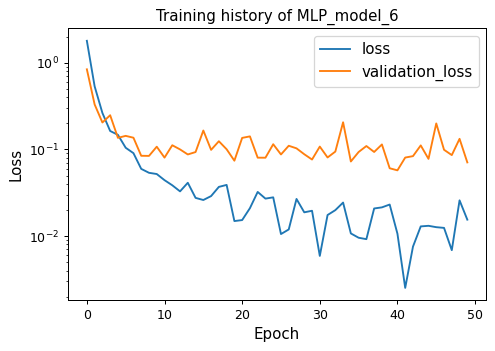

/tmp/ipykernel_18580/2410148466.py:127: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  class_ids = y.astype(np.int)


              precision    recall  f1-score   support

           0       0.94      0.94      0.94        35
           1       0.91      0.98      0.95       335
           2       0.98      0.93      0.95       328
           3       0.99      0.98      0.99       204
           4       0.99      1.00      0.99       297
           5       0.96      0.93      0.94       251
           6       1.00      0.98      0.99        63
           7       0.97      0.96      0.97       225
           8       0.96      0.97      0.97       213
           9       1.00      1.00      1.00       242
          10       1.00      1.00      1.00       324
          11       0.99      1.00      0.99       196
          12       1.00      0.99      1.00       304
          13       1.00      1.00      1.00       328
          14       1.00      1.00      1.00       111
          15       0.99      0.98      0.99       103
          16       1.00      1.00      1.00        75
          17       1.00    

In [7]:
# summary
best_model.model.summary()
# Plot loss history
# clf = best_model
best_model.plotLossHistory()

# Evaluate Model
best_model.evaluate()

<AxesSubplot:title={'center':'Confusion matrix with ony false classificaitons'}>

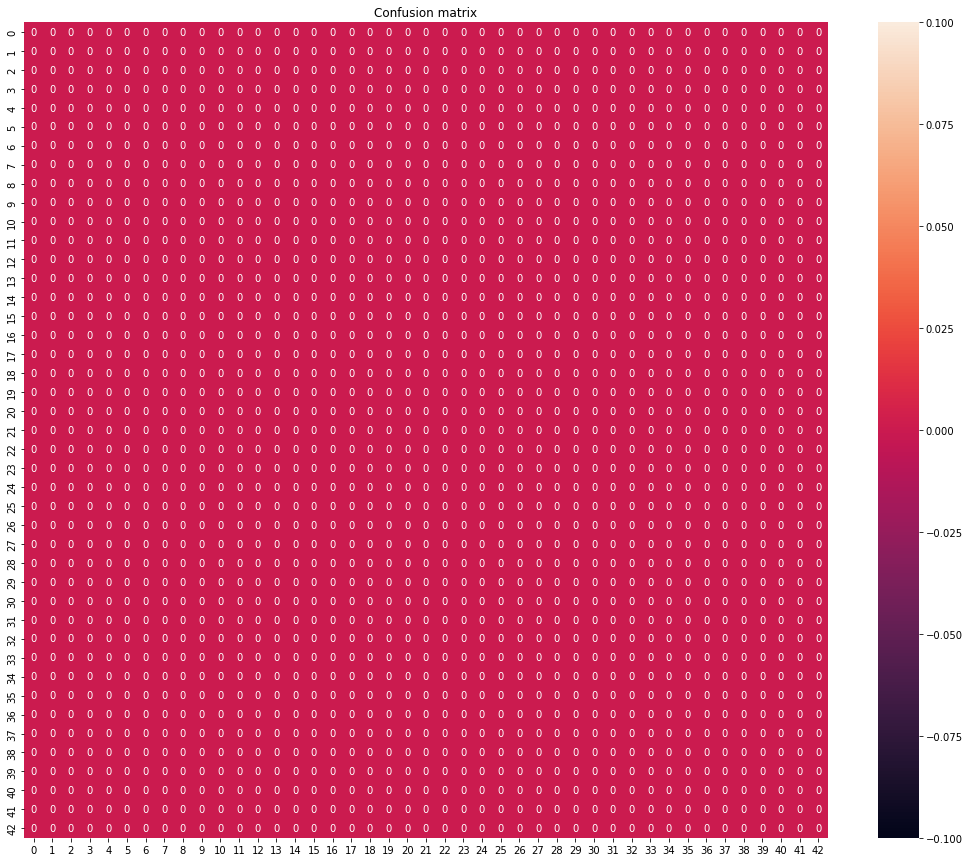

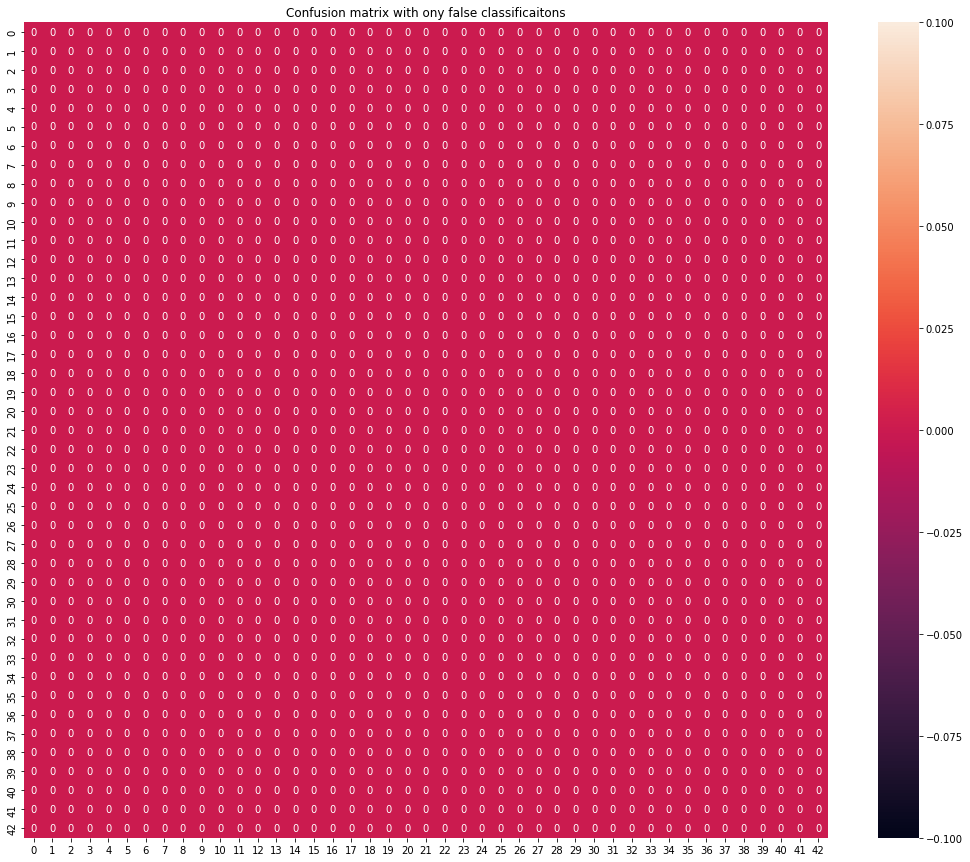

In [10]:
# Define confusion matrix
conf_matrix = best_model.confusion_matrix
unique_labels = best_model.unique_labels

# Plot confusion matrix
df_cm = pd.DataFrame(conf_matrix, index = unique_labels, columns = unique_labels)
fig = plt.figure(figsize = (18,15))
plt.title("Confusion matrix")
sn.heatmap(df_cm, annot=True)


# Plot matrix of only false classifications
conf_matrix_normalized = conf_matrix - np.diag(conf_matrix) * np.eye(len(conf_matrix))
df_cm_normalized = pd.DataFrame(conf_matrix_normalized, index = unique_labels, columns = unique_labels)
fig = plt.figure(figsize = (18,15))
plt.title("Confusion matrix with ony false classificaitons")
sn.heatmap(df_cm_normalized, annot=True)